Inicialización del programa - 24 June, 2015

In [69]:
%matplotlib inline
import pandas as pd
import transit
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import triangle
import scipy as sp
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 10,8  # Default image size for this interactive session

import astroML 
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=10, usetex=True)

Properties of the planet candidate and its host star.

In [18]:
#Properties of Planet Candidate (Data taken from Spreadsheet)
depth = 0.15*0.01 # (In absolute terms)
period = 19.306566 # (In days)
ecc = 0.0
b = 0.5

t0 = 1919.57971 # (-2454900) 
Rp = 3.47 
Mp = 31.87

#Star properties (from http://arxiv.org/pdf/1503.07866v1.pdf)
mass = 0.93
masserr = (0.05+0.06)/2.0
radius = 0.93
radiuserr = (0.05+0.06)/2.0
Teff = 5553

# From Claret (From Roberto's USPmass program)
u1 = 0.44 
u2 = 0.24
diffLD = u1-u2

# Kepler cadence
tKep = 29.42/(60.0*24.0)

Upload the photometric data and print the raw LC.

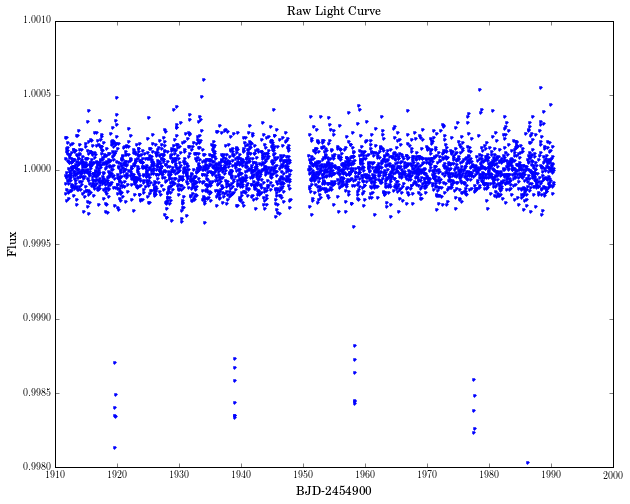

In [49]:
import glob, os
os.chdir("/Users/mariona/Desktop/summer2015")
for file in glob.glob("LCfluxesepic*.txt"):
    data = pd.read_table(file, sep='\s+', header = None, names=['time', 'flux','other'])
    timeLC = data['time']
    fluxLC = data['flux']
    errorLC = np.std(fluxLC)
    meanFlux = np.mean(fluxLC)
    goodP = fluxLC<=meanFlux+3*errorLC
    plt.figure(1)
    plt.plot(timeLC[goodP], fluxLC[goodP],'.')
    plt.xlabel('BJD-2454900', fontsize=12)
    plt.ylabel('Flux', fontsize=12)
    plt.title('Raw Light Curve',fontsize=12)

In [20]:
minTime = min(timeLC) 
maxTime = max(timeLC)

def my_range(start, end, step):
    while start <= end:
        yield start
        start += step
        
minepoch = -10
maxepoch = 20
numepochs = maxepoch-minepoch+1

transitLoc = np.empty(numepochs)

for x in my_range(minepoch, maxepoch, 1):
    transit = t0+x*period
    transitLoc[x-minepoch]=transit
    
goodTrans = (transitLoc<=maxTime) & (transitLoc>=minTime) # Returns boolean
transits = transitLoc[goodTrans] # Stores transit times

[ 1919.57971   1938.886276  1958.192842  1977.499408]


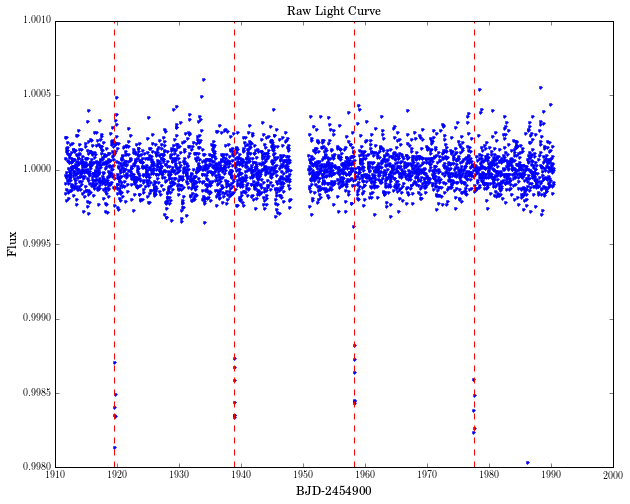

In [50]:
print transits
num_transits = len(transits)
plt.figure(2)
plt.plot(timeLC[goodP], fluxLC[goodP],'.')
plt.xlabel('BJD-2454900', fontsize=12)
plt.ylabel('Flux', fontsize=12)
plt.title('Raw Light Curve',fontsize=12)
for i in range(0,num_transits):
    plt.axvline(transits[i],color='r',ls='dashed')

Select the points that are "transit_window" hours to the left and to the right of the transit.

In [51]:
t=timeLC[goodP]
f=fluxLC[goodP]
transit_window = 8.0 #In hours
window = transit_window/24 # In days

sumPoints=0

for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   sumPoints=np.sum(selPoints)+sumPoints

#print sumPoints #Cantidad total de puntos en los 4 tránsitos en la franja que nos interesa

timeTrans = np.empty(sumPoints)
fluxTrans = np.empty(sumPoints)
flag = np.empty(sumPoints)
midTrans = np.empty(sumPoints)

sumPoints = 0
for i in range(0,len(transits)):
   selPoints=np.abs(t - transits[i])<=window
   numPoints = np.sum(selPoints)
   timeTrans[0+sumPoints:numPoints+sumPoints] = t[selPoints]
   fluxTrans[0+sumPoints:numPoints+sumPoints] = f[selPoints]
   flag[0+sumPoints:numPoints+sumPoints] = i
   midTrans[0+sumPoints:numPoints+sumPoints] = transits[i] 
   sumPoints = numPoints + sumPoints 

Plot the folded light curve.

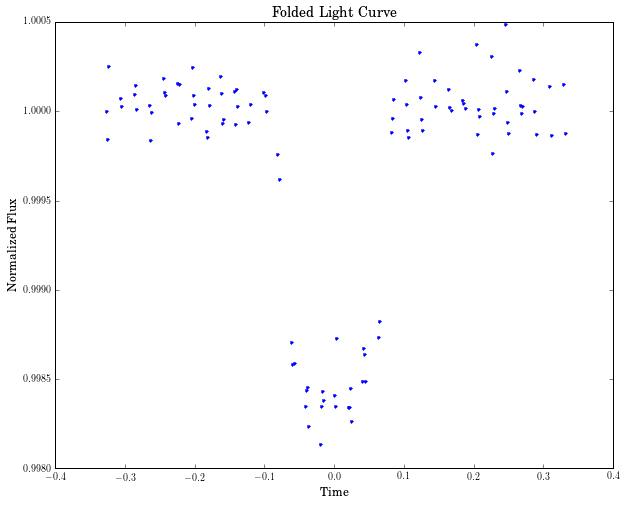

In [53]:
dt = timeTrans-midTrans
plt.plot(dt, fluxTrans,'.')
plt.title('Folded Light Curve', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Normalized Flux', fontsize=12)

From the figure above, we visually estimate that the transit occurs within a range of "rangeTransit." In this case, it's roughly +-0.1.

In [54]:
rangeTransit = 0.1
dataBool = np.abs(dt)>=rangeTransit # If true, point is outside of the transit.
out = (timeTrans<=rangeTransit) & (timeTrans>=rangeTransit) # This is a boolean array that tells you which points are outside of the transit.

The next window allows you to plot each transit. 

Fit the regions outside each transit. 

Divide the "light curve" of each transit by the fit obtained in the previous window.

In [66]:
#plt.figure(5)
corFlux=fluxTrans
for i in range(0,len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    #plt.subplot(2,2,i+1)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    #plt.plot(dt[transitBool],fluxTrans[transitBool],'.')
    #plt.plot(dt[transitBool],fluxTrans[transitBool]/p(dt[transitBool]),'.')
    #plt.xlabel('Time')
    #plt.ylabel('Flux')
    #plt.show()
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

Let's try to generalize the code done in the file LC_Analysis2 (which only dealth with Transit 1).

In [71]:
# The following parameters are the best estimates obtained from the code "LCAnalysis_1," also available on Github.
depth_ml = 0.0015669276217474255
b_ml = 0.62688198679744078
sigma_ml = 4.0382821939991208e-11
sumLD_ml = 0.62054242543638494
mass_ml = 0.92718951248481241 #Best guess for mass of the star
radius_ml = 0.94091569399602548 #Best guess for radius of the star
f0_ml = 1.0000012139894519

# We will keep all the variables fixed except for the transit time.
allfixed = [period, ecc,  mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sigma_ml, 
            sumLD_ml, mass_ml, radius_ml, f0_ml]

Calculates the log of the likelihood of the transit model being the right model with the transit time as our free parameter (pt0_i, where i represents the transit being analyzed). Note: theta[0] = pt0_i.

In [77]:
def lnlike(theta, timeLC, fluxLC, errorLC, allfixed):

    pt0_i = theta
    period, ecc,mass, masserr, radius, radiuserr, diffLD, tKep, depth_ml, b_ml, sigma_ml, sumLD_ml, mass_ml, radius_ml, f0_ml = allfixed 
    
    u1 = 0.5*(sumLD_ml+diffLD) 
    u2 = sumLD_ml-u1
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass=mass_ml,radius=radius_ml))
    body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=pt0_i, b=np.abs(b_ml), e=ecc)
    s.add_body(body)
    
    inv_sigma2 = 1.0/(errorLC**2 + sigma_ml**2)
    
    ftheo = s.light_curve(timeLC, texp=tKep, tol=1e-08, maxdepth=4)  
    ftheo = ftheo-1+f0_ml
    
    return -0.5*(np.sum((fluxLC-ftheo)**2*inv_sigma2 - np.log(inv_sigma2)) + ((mass_ml-mass)/masserr)**2
            + ((radius_ml-radius)/radiuserr)**2)

In [78]:
def optim (transitNum, timeLC, fluxLC, errorLC, allfixed):
    n3 = lambda *args: -lnlike(*args)
    result = op.minimize(n3, transits[transitNum], args=(t_i, corFlux_i, errorLC, allfixed), options={'disp': True}, method='Nelder-Mead')
    t0fit = result["x"]
    return t0fit

In [82]:
corFlux=fluxTrans 
t0fit=[]
for i in range(len(transits)):
    transitBool=(flag==i)
    outsideBool=(np.abs(dt)>=rangeTransit) & (flag==i)
    z=np.polyfit((dt[outsideBool]), fluxTrans[outsideBool], 1)
    p=np.poly1d(z)
    corFlux[transitBool]=fluxTrans[transitBool]/p(dt[transitBool])

    dt_i=dt[transitBool] # timeTrans-midTrans for transit i
    t_i=timeTrans[transitBool] # timeTrans for transit i
    corFlux_i=corFlux[transitBool] #corrected flux for transit i.
    
    aux = optim(i, t_i, corFlux_i, errorLC, allfixed)
    t0fit.append(aux)

Optimization terminated successfully.
         Current function value: -245.957094
         Iterations: 22
         Function evaluations: 52
Optimization terminated successfully.
         Current function value: -247.052334
         Iterations: 21
         Function evaluations: 51
Optimization terminated successfully.
         Current function value: -205.811135
         Iterations: 23
         Function evaluations: 55
Optimization terminated successfully.
         Current function value: -174.406125
         Iterations: 21
         Function evaluations: 51
[array([ 1919.57833701]), array([ 1938.88387221]), array([ 1958.19088115]), array([ 1977.49629628])]


The best estimates for the transit times of the raw LC are given by the list "t0fit". 

In [86]:
print t0fit

[array([ 1919.57833701]), array([ 1938.88387221]), array([ 1958.19088115]), array([ 1977.49629628])]


Compute each transit LC integrated over a Kepler long cadence exposure time with the result derived from optimization. Then, plot it.

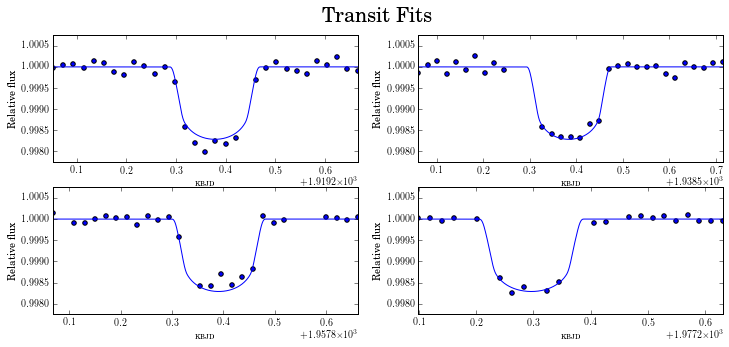

In [138]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('Transit Fits', fontsize=20)

for i in range(len(transits)):
    
    s = transit.System(transit.Central(mu1=u1, mu2=u2, mass = mass_ml, radius = radius_ml))
    body = transit.Body(r=np.sqrt(depth_ml)*radius_ml, period=period, t0=t0fit[i], b=np.abs(b_ml), e=ecc)
    s.add_body(body)

    t_theory = np.arange(-1, 1, tKep*0.01) + t0fit[i] # KBJD (Reduced BJD, i.e. BJD-2454900)
    f_theory = s.light_curve(t_theory, texp=tKep, tol=1e-08, maxdepth=4)
    f_theory = f_theory-1.0+f0_ml
    
    ax = fig.add_subplot(2,2,i+1)
    ax.scatter(timeTrans[flag==i],corFlux[flag==i])
    plt.xlim([min(timeTrans[flag==i]), max(timeTrans[flag==i])]) 
    plt.ylim([1-depth*1.5, depth*0.5+1]) 
    ax.set_xlabel('KBJD', fontsize=7)
    ax.set_ylabel('Relative flux', fontsize=10)
    ax.plot(t_theory, f_theory)

plt.savefig('transitFits.png')

With the best fit solutions, we'll run an MCMC routine to estimate the uncertainties on the parameters.

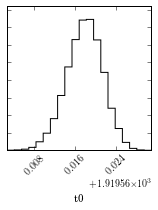

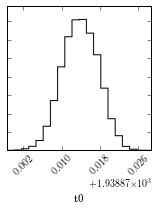

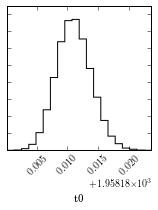

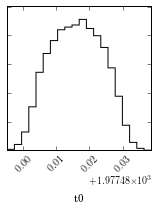

In [188]:
ndim, nwalkers = 1, 100 # 1 dimension because we're only fitting 1 parameter.
steps = 1000

t0fit_mcmc=np.zeros((len(transits),3)) 
'''
    Each row corresponds to a specific transit (row 1 = transit 1, etc.). 
    Column 1 = Best estimate for transit time.
    Column 2 = + Error of transit time.
    Column 3 = - Error of transit time.
'''

fig = plt.figure(7)
for i in range(len(transits)):
    pos = [t0fit[i]*(1+1e-5*np.random.randn(ndim)) for j in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(timeTrans[flag==i], corFlux[flag==i], errorLC, allfixed))
    sampler.run_mcmc(pos, steps)
    samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

    # ax = fig.add_subplot(2,2,i+1)
    fig = triangle.corner(samples, labels=["t0"])
    
    v = np.percentile(samples, [15.84, 50, 84.16], axis=0)
    t0fit_mcmc[i,0] = v[1] # 3rd value is the best estimate for t0 (it falls at the center)
    t0fit_mcmc[i,1] = v[2]-v[1] #+ Error of t0
    t0fit_mcmc[i,2] = v[1]-v[0] #- Error of t0

plt.savefig('triangles.png')

In [189]:
print t0fit_mcmc

[[  1.91957792e+03   3.33858013e-03   3.66233334e-03]
 [  1.93888391e+03   3.84655472e-03   3.80380070e-03]
 [  1.95819097e+03   2.93526001e-03   2.70859689e-03]
 [  1.97749626e+03   8.41503370e-03   8.57718237e-03]]


In [190]:
np.savetxt('Estimates of Transit Times.txt', t0fit_mcmc, fmt='%1.3f', delimiter='   ',
            header = """Each row represents a transit in the light curve (i.e. row 1 = transit 1, 
            row 2 = transit 2, etc.). The first column shows the best estimate for the transit time of that 
            particular transit (50% percentile). The second and third give, respectively, the upper and lower
            errors for such guess.""") 